In [1]:
# Autoreload 
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.utilities.rank_zero import rank_zero_only # NEW
from datetime import datetime

# Bacis libraries #
import os   
from dotenv import load_dotenv
load_dotenv('/home/pk21271/keys/key.env')
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from regressor import AnalysisObjectTransformer, Embedding
from losses import *
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")


Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

# Main path
main_path = '/home/pk21271/prep_data/ttH_regressor'

# File paths
x_path = os.path.join(main_path, 'X.pt')
y_path = os.path.join(main_path, 'y.pt')
pad_mask_path = os.path.join(main_path, 'pad_mask.pt')
reweighting_path = os.path.join(main_path, 'reweighting.pt')
weight_nom_path = os.path.join(main_path, 'weight_nom.pt')
event_level_path = os.path.join(main_path, 'event_level.pt')
phi_path = os.path.join(main_path, 'phi.pt')
target_reg_path = os.path.join(main_path, 'target_reg.pt')

# Load data
X = torch.load(x_path)
y = torch.load(y_path)
pad_mask = torch.load(pad_mask_path)
reweighting = torch.load(reweighting_path)
weight_nom = torch.load(weight_nom_path)
event_level = torch.load(event_level_path)
phi = torch.load(phi_path)
target_reg = torch.load(target_reg_path)

# Get rid of data with target_reg > 600 which is still 99% of data

# X = X[target_reg < 600]
# y = y[target_reg < 600]
# pad_mask = pad_mask[target_reg < 600]
# reweighting = reweighting[target_reg < 600]
# weight_nom = weight_nom[target_reg < 600]
# event_level = event_level[target_reg < 600]
# phi = phi[target_reg < 600]
# target_reg = target_reg[target_reg < 600]


## Create training datasets ## Also added the nominal weights
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event, train_nom, val_nom, train_phi, val_phi, train_target, val_target  = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level,
    weight_nom,
    phi,
    target_reg,
    test_size=0.2,  
    random_state=42,
)

# Scale the target_reg with standard scaler

# Convert to 2D NumPy arrays for StandardScaler:
train_target_np = train_target.unsqueeze(1).detach().cpu().numpy()
val_target_np   = val_target.unsqueeze(1).detach().cpu().numpy()

from sklearn.preprocessing import StandardScaler
scaler_target = StandardScaler()
train_target_scaled = scaler_target.fit_transform(train_target_np)
val_target_scaled   = scaler_target.transform(val_target_np)

scaler_event = StandardScaler()
train_event_scaled = scaler_event.fit_transform(train_event)
val_event_scaled  = scaler_event.transform(val_event)

# Convert back to torch tensors
train_target_scaled = torch.tensor(train_target_scaled, dtype=torch.float32)
val_target_scaled   = torch.tensor(val_target_scaled, dtype=torch.float32)
train_event_scaled = torch.tensor(train_event_scaled, dtype=torch.float32)
val_event_scaled   = torch.tensor(val_event_scaled, dtype=torch.float32)

# Now all tensors have consistent dimensions for TensorDataset:
train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event, train_phi, train_target_scaled)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event, val_phi, val_target_scaled)

## Create loaders ##
batch_size = 1024

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = 11, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    num_workers = 11,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

/tmp/ipykernel_1319347/3015853605.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(x_path)
/tmp/ipykernel_1319347/3015853605.py:21: FutureWarning: You are

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


In [3]:
# fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
# fig = plot_inputs_per_label_multi(X,y,pad_mask,bins=100,log=True,show=True)
# fig = plot_inputs_per_label_multi(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

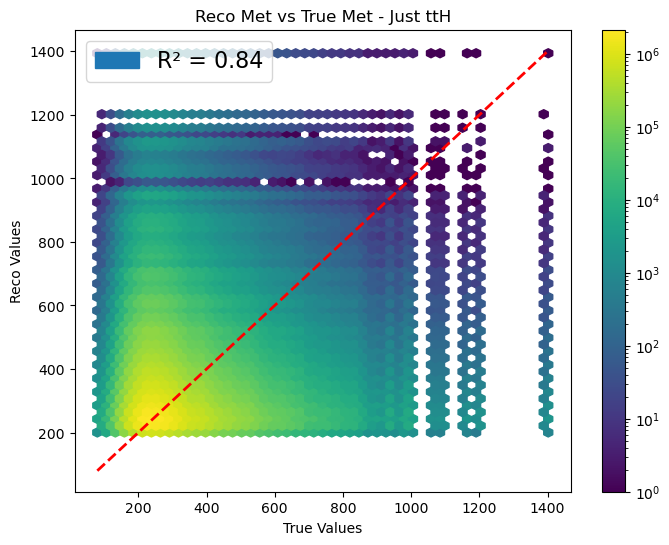

In [4]:
# Plot the Gen Met vs Input Met aka the target_reg vs event

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score

def plot_regression_results(y_true, y_pred, sample_size=1000, cmap='viridis'):
    """
    Plots predicted vs true values for regression with density coloring (log scale).
    
    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values
    - cmap: str, colormap for density
    """
    plt.figure(figsize=(8, 6), dpi=100)

    r2_value = r2_score(y_true, y_pred)
    
    # Use LogNorm for log-scaled density visualization

    if len(y_true) > sample_size:
            sampled_indices = np.random.choice(len(y_true), sample_size, replace=False)
            y_true = y_true[sampled_indices]
            y_pred = y_pred[sampled_indices]

    hb = plt.hexbin(y_true, y_pred, gridsize=50, cmap=cmap, mincnt=1, bins='log')

    # Add colorbar
    cb = plt.colorbar(hb)

    # Plot y = x line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y = x')

    # Labels and title
    plt.xlabel("True Values")
    plt.ylabel("Reco Values")

    plt.title("Reco Met vs True Met - Just ttH")
    
    # Add legend with R and R^2 scores
    plt.legend([f"R² = {r2_value:.2f}"], fontsize=16)
    
    plt.show()

# Select first 10,000 samples for faster plotting, 10k works

points = 10000
plot_regression_results(val_target.numpy(), val_event.numpy(), sample_size=points)

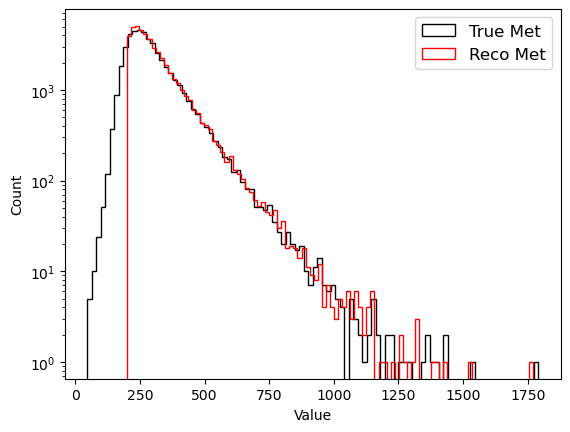

In [5]:
# Plot histogram of val_target

plt.hist(val_target, bins=100, histtype='step', color='k', label='True Met')
plt.hist(val_event, bins=100, histtype='step', color='r', label='Reco Met')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend(fontsize=12)
plt.yscale('log')
# plt.title('Distribution of RecoMet and GenMet')
plt.show()

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [6]:
# Define model #

# Loss function for regression
loss_function = nn.MSELoss ()

# loss = BCE + lambda * decorrelated loss # Lambda determines the strength of the decorrelation loss
# lambda = 0 -> pure BCE

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension  
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)

output_dim = len(torch.unique(y)) if len(torch.unique(y)) > 2 else 1

print(output_dim)

# Choose number of layers
enc = 5
cla = 2
dnn = 3

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance 
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim) 
    output_dim = output_dim,         # Output dimension (1 : binary classification, >1 : multi classification) 
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor) norm is 4
    encoder_layers = enc,              # Number of encoder layers (self attention on jets)
    class_layers = cla,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = dnn,                  # Number of layers for DNN after the transformer
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.1,                   # Dropout rate - default was 0.1
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print(model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event, phi, target = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask, reco_met=event, phi=phi)
print ('outputs', outputs.shape)
loss_values = loss_function(outputs, target)
print ('losses',loss_values)

1
AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (dnn): Sequenti

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [7]:
##### Parameters #####

# Choose max epochs and learning rate
epochs = 150
# lr = 1e-4 # Probs use this 
# lr = 5e-4
lr = 1e-4 # This lr is too high for 128, 8,2,3


print(len(train_dataset), len(valid_dataset))

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.2, 
   patience = 4, #Was 10
   threshold = 0., 
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=8,          # Number of epochs with no improvement after which training will be stopped #Defacult was 30, changed to 8
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback(name='ROC'),
        ConfusionMatrixSubCallback(name='CM'),
    ]
)

## Logger ##
# logger = CometLogger(
#     api_key = os.environ.get("COMET_API_KEY"), 
#     project_name = "AnalysisObjectTransformer",
#     experiment_name = "Setup",
#     save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
#     offline = False  # Set to True for offline mode


## Logger ## (THIS IS THE NEW ONE WITH THE PATH SETUP)
logger = CometLogger(
    api_key = os.getenv("COMET_API_KEY"),
    project_name = "AnalysisObjectTransformer",
    experiment_name = f"Mult {enc},{cla},{dnn} | lr={lr}",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    strategy = "ddp_notebook",
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = [0,1,2,3,4,5],  # Use only one GPU
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train, # This is logging the wrong number
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [  # Remove the plotting callbacks 
        early_stopping,
        log_bar,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)
trainer.save_checkpoint(f"{outdir}/model.pt")

187880 46971
Training   : Batch size = 1024 => 184 steps per epoch
Validation : Batch size = 10000 => 5 steps per epoch


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/6
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/6
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/6
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/6
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/6
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/6
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 6 processes
----------------------------------------------------------------------------------------------------

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=184). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved. New best score: 1.143
[rank: 4] Metric val/loss_tot improved. New best score: 1.143
[rank: 3] Metric val/loss_tot improved. New best score: 1.143
[rank: 5] Metric val/loss_tot improved. New best score: 1.143
[rank: 1] Metric val/loss_tot improved. New best score: 1.143
[rank: 2] Metric val/loss_tot improved. New best score: 1.143


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.519 >= min_delta = 0.0. New best score: 0.624
[rank: 3] Metric val/loss_tot improved by 0.519 >= min_delta = 0.0. New best score: 0.624
[rank: 4] Metric val/loss_tot improved by 0.519 >= min_delta = 0.0. New best score: 0.624
[rank: 5] Metric val/loss_tot improved by 0.519 >= min_delta = 0.0. New best score: 0.624
[rank: 2] Metric val/loss_tot improved by 0.519 >= min_delta = 0.0. New best score: 0.624
[rank: 1] Metric val/loss_tot improved by 0.519 >= min_delta = 0.0. New best score: 0.624


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.263 >= min_delta = 0.0. New best score: 0.361
[rank: 3] Metric val/loss_tot improved by 0.263 >= min_delta = 0.0. New best score: 0.361
[rank: 4] Metric val/loss_tot improved by 0.263 >= min_delta = 0.0. New best score: 0.361
[rank: 5] Metric val/loss_tot improved by 0.263 >= min_delta = 0.0. New best score: 0.361
[rank: 1] Metric val/loss_tot improved by 0.263 >= min_delta = 0.0. New best score: 0.361
[rank: 2] Metric val/loss_tot improved by 0.263 >= min_delta = 0.0. New best score: 0.361


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.132 >= min_delta = 0.0. New best score: 0.229
[rank: 4] Metric val/loss_tot improved by 0.132 >= min_delta = 0.0. New best score: 0.229
[rank: 3] Metric val/loss_tot improved by 0.132 >= min_delta = 0.0. New best score: 0.229
[rank: 2] Metric val/loss_tot improved by 0.132 >= min_delta = 0.0. New best score: 0.229
[rank: 1] Metric val/loss_tot improved by 0.132 >= min_delta = 0.0. New best score: 0.229
[rank: 5] Metric val/loss_tot improved by 0.132 >= min_delta = 0.0. New best score: 0.229


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.066 >= min_delta = 0.0. New best score: 0.164
[rank: 4] Metric val/loss_tot improved by 0.066 >= min_delta = 0.0. New best score: 0.164
[rank: 3] Metric val/loss_tot improved by 0.066 >= min_delta = 0.0. New best score: 0.164
[rank: 1] Metric val/loss_tot improved by 0.066 >= min_delta = 0.0. New best score: 0.164
[rank: 2] Metric val/loss_tot improved by 0.066 >= min_delta = 0.0. New best score: 0.164
[rank: 5] Metric val/loss_tot improved by 0.066 >= min_delta = 0.0. New best score: 0.164


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 0.151
[rank: 3] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 0.151
[rank: 4] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 0.151
[rank: 5] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 0.151
[rank: 2] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 0.151
[rank: 1] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 0.151


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.151
[rank: 4] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.151
[rank: 5] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.151
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.151
[rank: 3] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.151
[rank: 1] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.151


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.147
[rank: 5] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.147
[rank: 3] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.147
[rank: 4] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.147
[rank: 1] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.147
[rank: 2] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.147


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.147. Signaling Trainer to stop.
[rank: 5] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.147. Signaling Trainer to stop.
[rank: 3] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.147. Signaling Trainer to stop.
[rank: 4] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.147. Signaling Trainer to stop.
[rank: 1] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.147. Signaling Trainer to stop.
[rank: 2] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.147. Signaling Trainer to stop.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO

In [8]:
## Testing model performance on validation set ##
single_gpu_trainer = L.Trainer(accelerator="gpu", devices=1)
preds = single_gpu_trainer.predict(model=model, dataloaders=valid_loader)

preds = torch.cat(preds, dim=0)

inputs, labels, weights, mask, event, phi, target = valid_dataset.tensors

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: |          | 0/? [00:00<?, ?it/s]

# Regression Metrics

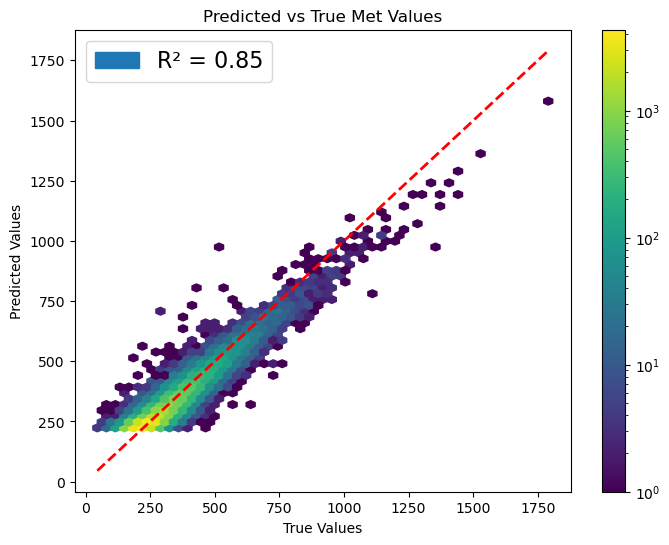

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score

def plot_regression_results(y_true, y_pred, cmap='viridis'):
    """
    Plots predicted vs true values for regression with density coloring (log scale).
    
    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values
    - cmap: str, colormap for density
    """
    plt.figure(figsize=(8, 6), dpi=100)

    r2_value = r2_score(y_true, y_pred)
    
    # Use LogNorm for log-scaled density visualization
    hb = plt.hexbin(y_true, y_pred, gridsize=50, cmap=cmap, mincnt=1, bins='log')

    # Add colorbar
    cb = plt.colorbar(hb)

    # Plot y = x line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y = x')

    # Labels and title
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")

    plt.title("Predicted vs True Met Values")
    
    # Add legend with R and R^2 scores
    plt.legend([f"R² = {r2_value:.2f}"], fontsize=16)
    
    plt.show()

# Untransform the target
target_unscaled = scaler_target.inverse_transform(target.numpy())
preds_unscaled = scaler_target.inverse_transform(preds.numpy())

plot_regression_results(target_unscaled, preds_unscaled)

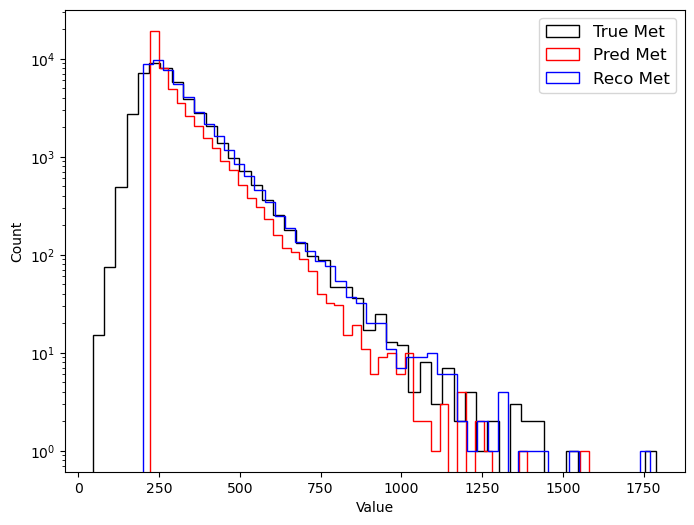

(46971, 1)
(46971, 1)
torch.Size([46971, 1])


In [10]:
plt.figure(figsize=(8, 6), dpi=100)
plt.hist(target_unscaled, bins=50, histtype='step', color='k', label='True Met')
plt.hist(preds_unscaled, bins=50, histtype='step', color='r', label='Pred Met')
plt.hist(val_event, bins=50, histtype='step', color='b', label='Reco Met')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend(fontsize=12)
plt.yscale('log')
# plt.ylim(1000,10000)
# plt.title('Distribution of RecoMet and PredictedMet')
plt.show()

print(target_unscaled.shape)
print(preds_unscaled.shape)
print(val_event.shape)

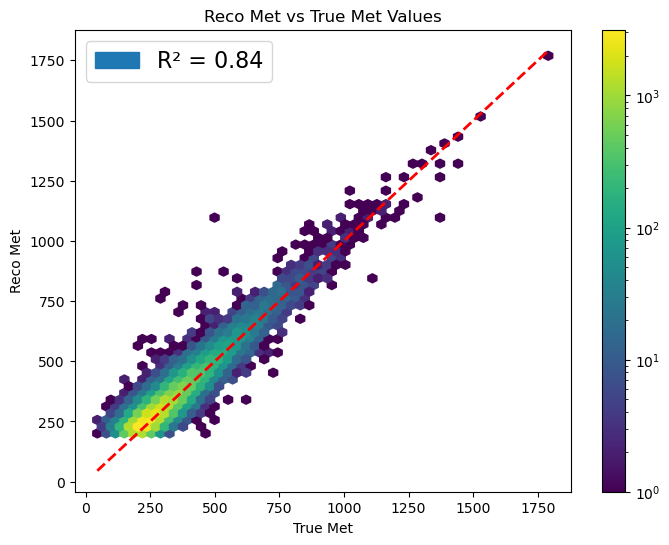

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score

def plot_regression_results(y_true, y_pred, cmap='viridis'):
    """
    Plots predicted vs true values for regression with density coloring (log scale).
    
    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values
    - cmap: str, colormap for density
    """
    plt.figure(figsize=(8, 6), dpi=100)

    r2_value = r2_score(y_true, y_pred)
    
    # Use LogNorm for log-scaled density visualization
    hb = plt.hexbin(y_true, y_pred, gridsize=50, cmap=cmap, mincnt=1, bins='log')

    # Add colorbar
    cb = plt.colorbar(hb)

    # Plot y = x line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y = x')

    # Labels and title
    plt.xlabel("True Met")
    plt.ylabel("Reco Met")

    plt.title("Reco Met vs True Met Values")
    
    # Add legend with R and R^2 scores
    plt.legend([f"R² = {r2_value:.2f}"], fontsize=16)
    
    plt.show()

# Example usage

plot_regression_results(target_unscaled, val_event.numpy())
